<a href="https://colab.research.google.com/github/CalebBrunton2/mgmt467-analytics-portfolio/blob/main/Unit1_Labs/Lab_3_Data_Visualization_Dashboarding/Week5_DataViz_Dashboarding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MGMT 467 — Week 5: Data Visualization & Dashboarding

Instructor: **Prof. Alok R. Chaturvedi**  
Modality: **Guided Inquiry (Tuesday)** + **Hands-on Lab (Thursday)**  
Prepared: 2025-09-23  

---
### Learning Objectives
1. Distinguish **exploratory** vs **explanatory** visualization.  
2. Match common **chart types** to the **questions** they answer.  
3. Design **airline KPIs** and select appropriate visuals.  
4. Use **Gemini** to generate Matplotlib/Seaborn code in Colab.  
5. Build an **interactive dashboard** in Looker Studio using BigQuery/CSV.


## Tuesday (Concepts) — Guided Inquiry

**Instructions:** Answer directly in this notebook. Use short paragraphs and bullet points. When helpful, sketch chart ideas using ASCII or quick scribbles.

### Q1 — Exploratory vs. Explanatory
**Prompt:** *"Explain the difference between exploratory and explanatory visualization."*  
**Hints:** Consider audience, purpose, level of polish, and how much iteration you expect.

📝 **Your response:**

-
-
-

---
### Q2 — Chart Types & When to Use Them
**Prompt:** *"Describe 5 common chart types (e.g., bar, line, scatter, histogram, map) and the type of data analysis question each is best suited to answer."*  

For each chart, list: **Question archetype**, **Data shape**, **Pitfalls**, **Alternatives**.

📝 **Your response (template):**
1. **Bar:**  
   - Question archetype:  
   - Data shape:  
   - Pitfalls:  
   - Alternatives:  
2. **Line:**  
3. **Scatter:**  
4. **Histogram:**  
5. **Map:**  

---
### Q3 — Airline Executive Dashboard KPIs
**Prompt:** *"Your goal is to create a dashboard for an airline executive. Brainstorm 5 Key Performance Indicators (KPIs) that should be on this dashboard. For each KPI, suggest the best chart type to visualize it."*

Suggested KPI ideas to consider (customize them): On-Time Rate, Average Delay Minutes, Cancellation Rate, Load Factor, Yield (Revenue per Passenger Mile), Completion Factor, Net Promoter Score (if available), Revenue, Cost per Available Seat Mile (CASM).

📝 **Your response (template):**
1. KPI:  
   - Why it matters:  
   - Best chart:  
   - Drill-down fields:  
2. KPI:  
3. KPI:  
4. KPI:  
5. KPI:  


---
## Thursday (Practice) — Colab, Gemini, & Looker Studio

You will:
1) Use **Gemini** in Colab to generate visualization code (Matplotlib/Seaborn).  
2) Use a **synthetic airline dataset** (provided below) *or* connect your own BigQuery data.  
3) Build a **Looker Studio** dashboard for your KPIs.

### Option A — Use Gemini Side Panel in Colab
Open the **Gemini** side panel in Colab ("Extensions" or the right sidebar). Ask it to generate Python code given your prompts and the DataFrame you have in memory. Paste/execute the generated code in new cells.

### Option B — Programmatic Gemini (optional)
If you prefer code, you can install the Generative AI SDK and call Gemini with an API key. (We will not store keys in this notebook.)

> **Reminder:** This course emphasizes **AI-assisted coding**—focus on specifying *clear prompts* and then **reviewing and editing** the generated code for correctness, readability, and ethics.


In [1]:
# (Optional) Environment setup — run if needed
%%capture
!pip install pandas numpy matplotlib seaborn pyarrow db-dtypes google-cloud-bigquery -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
np.random.seed(42)
print('✅ Environment ready')

### Create a Synthetic Airline Dataset (if you don't have one)
Use this dataset to prototype visualizations and dashboards. It contains realistic columns for the KPIs you defined. You can always swap in your BigQuery data later.


In [3]:
# Generate a synthetic airline dataset
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

np.random.seed(467)

dates = pd.date_range(start='2024-01-01', end='2024-06-30', freq='D')
carriers = ['AA', 'DL', 'UA', 'WN', 'AS']
origins = ['ATL','DFW','DEN','ORD','LAX','SEA','SFO','PHX','CLT','MCO']
dests =   ['JFK','LGA','BOS','SFO','LAX','SEA','MIA','IAH','IAD','PHL']

rows = []
for d in dates:
    for carrier in carriers:
        # number of flights per day per carrier
        n = np.random.randint(80, 140)
        for _ in range(n):
            o = np.random.choice(origins)
            de = np.random.choice(dests)
            if o == de:
                continue
            distance = np.random.randint(300, 2800)
            seats = np.random.choice([90,120,150,180,210])
            load_factor = np.clip(np.random.normal(0.82, 0.07), 0.55, 0.98)
            pax = int(seats * load_factor)
            dep_delay = int(np.random.normal(8, 15))
            arr_delay = dep_delay + int(np.random.normal(0, 12))
            dep_delay = max(dep_delay, -5)
            arr_delay = max(arr_delay, -10)
            cancelled = np.random.rand() < 0.025
            diverted = np.random.rand() < 0.005
            revenue = pax * np.random.uniform(120, 420)
            casm = np.random.uniform(0.08, 0.16)  # cost per available seat mile
            cost = casm * seats * distance
            fuel_burn = distance * np.random.uniform(3.0, 4.5)  # gallons per seat-mile proxy
            nps = np.random.normal(35, 15)  # if you want a customer metric proxy
            rows.append({
                'date': d,
                'carrier': carrier,
                'origin': o,
                'dest': de,
                'distance_miles': distance,
                'seats': seats,
                'passengers': pax,
                'dep_delay_min': dep_delay,
                'arr_delay_min': arr_delay,
                'cancelled': int(cancelled),
                'diverted': int(diverted),
                'revenue_usd': round(revenue, 2),
                'cost_usd': round(cost, 2),
                'fuel_burn_gal': round(fuel_burn, 1),
                'nps': round(nps, 1)
            })

df_flights = pd.DataFrame(rows)

# Derived KPIs
df_flights['on_time'] = (df_flights['arr_delay_min'] <= 15).astype(int)
df_flights['load_factor'] = (df_flights['passengers'] / df_flights['seats']).round(3)
df_flights['yield_usd_per_pax_mile'] = (df_flights['revenue_usd'] / (df_flights['passengers'] * df_flights['distance_miles']).clip(lower=1)).round(4)
df_flights['asm'] = df_flights['seats'] * df_flights['distance_miles']  # available seat miles
df_flights['casm'] = (df_flights['cost_usd'] / df_flights['asm']).round(4)
df_flights['month'] = df_flights['date'].dt.to_period('M').astype(str)

df_flights.head()

,date,carrier,origin,dest,distance_miles,seats,passengers,dep_delay_min,arr_delay_min,cancelled,...,revenue_usd,cost_usd,fuel_burn_gal,nps,on_time,load_factor,yield_usd_per_pax_mile,asm,casm,month
0,2024-01-01,AA,LAX,IAH,444,180,160,-5,-10,0,...,26076.49,8301.98,1904.6,53.4,1,0.889,0.3671,79920,0.1039,2024-01
1,2024-01-01,AA,SEA,PHL,601,150,141,10,7,0,...,17561.91,8739.75,2237.5,60.9,1,0.940,0.2072,90150,0.0969,2024-01
2,2024-01-01,AA,LAX,IAD,749,120,100,13,22,0,...,15355.61,12241.65,3076.5,54.1,0,0.833,0.2050,89880,0.1362,2024-01
3,2024-01-01,AA,DFW,BOS,2153,210,169,13,14,0,...,42122.37,65961.23,6642.2,37.0,1,0.805,0.1158,452130,0.1459,2024-01
4,2024-01-01,AA,CLT,SEA,558,90,75,9,-5,0,...,26418.88,7144.23,2142.3,56.3,1,0.833,0.6313,50220,0.1423,2024-01


### Use Gemini to Generate Visualization Code
Copy/paste these **prompts** into Gemini (Colab side panel). After it generates code, paste it into a new cell and run. **Inspect and fix** anything that looks off.

#### Prompt A — On-Time Rate by Carrier (Bar Chart)
```
You are a Python data viz expert. Given a pandas DataFrame `df_flights` with columns including `carrier` and `on_time` (1/0), write Matplotlib/Seaborn code to compute and plot **On-Time Rate by carrier** as a sorted bar chart with percentage labels on bars. Use a clean style, readable labels, and tight layout. Do not use Plotly.
```

#### Prompt B — Average Arrival Delay over Time (Line Chart)
```
Given `df_flights` with `date` (datetime) and `arr_delay_min`, write code to aggregate to daily average arrival delay and plot a **line chart** with a 7-day rolling average overlay. Add axis labels, title, and grid.
```

#### Prompt C — Delay Distribution (Histogram)
```
Given `df_flights` with `arr_delay_min`, write code to plot a **histogram** of arrival delays with appropriate bins, a vertical reference line at 0, and annotate percent of flights within [-5, 15] minutes.
```

#### Prompt D — Load Factor by Route (Top 15) (Horizontal Bar)
```
Given `df_flights` with `origin`, `dest`, and `load_factor`, compute mean load factor by route (origin-dest pair), take the top 15 routes by average load factor, and plot a **horizontal bar chart**. Ensure long labels are readable.
```

#### Prompt E — Cost vs. Revenue with CASM Coloring (Scatter)
```
Given `df_flights` with `cost_usd`, `revenue_usd`, and `casm`, produce a **scatter plot** of cost vs. revenue with points colored by `casm` (continuous colormap) and add a diagonal y=x reference line. Include labels and legend.
```


/tmp/ipython-input-1667398006.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=on_time_rate_by_carrier.index, y=on_time_rate_by_carrier.values, palette='viridis')


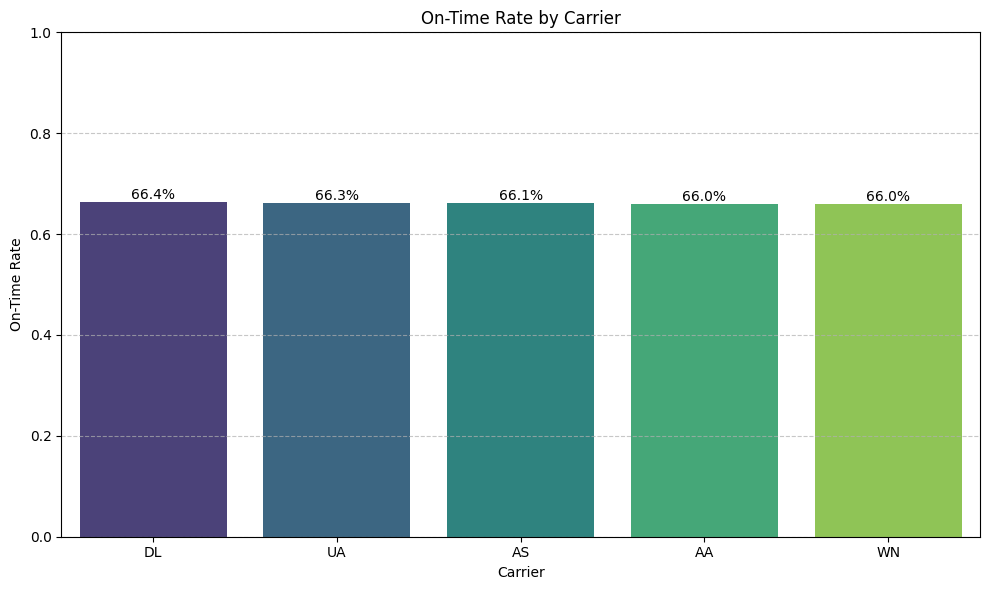

In [4]:
# Prompt A: On-Time Rate by Carrier (Bar Chart)

# Calculate on-time rate by carrier
on_time_rate_by_carrier = df_flights.groupby('carrier')['on_time'].mean().sort_values(ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=on_time_rate_by_carrier.index, y=on_time_rate_by_carrier.values, palette='viridis')

# Add percentage labels on bars
for p in ax.patches:
    percentage = f'{p.get_height():.1%}'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.title('On-Time Rate by Carrier')
plt.xlabel('Carrier')
plt.ylabel('On-Time Rate')
plt.ylim(0, 1) # Set y-axis limit to 0-1 for percentage
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Prompt B: Average Arrival Delay over Time (Line Chart)

# Aggregate to daily average arrival delay
daily_avg_delay = df_flights.groupby('date')['arr_delay_min'].mean()

# Calculate 7-day rolling average
rolling_avg_delay = daily_avg_delay.rolling(window=7).mean()

# Plot the line chart
plt.figure(figsize=(12, 6))
plt.plot(daily_avg_delay.index, daily_avg_delay.values, label='Daily Average Delay', alpha=0.7)
plt.plot(rolling_avg_delay.index, rolling_avg_delay.values, label='7-Day Rolling Average', color='red')

plt.title('Average Arrival Delay over Time')
plt.xlabel('Date')
plt.ylabel('Average Arrival Delay (minutes)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Prompt C: Delay Distribution (Histogram)

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_flights['arr_delay_min'], bins=50, kde=False)

# Add a vertical reference line at 0
plt.axvline(0, color='red', linestyle='--', label='0 Minute Delay')

# Annotate percent of flights within [-5, 15] minutes
on_time_flights = df_flights[(df_flights['arr_delay_min'] >= -5) & (df_flights['arr_delay_min'] <= 15)]
percent_on_time = len(on_time_flights) / len(df_flights) * 100

plt.text(15, plt.ylim()[1]*0.9, f'{percent_on_time:.1f}% flights within [-5, 15] min',
         horizontalalignment='left', color='green')

plt.title('Distribution of Arrival Delays')
plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Prompt D: Load Factor by Route (Top 15) (Horizontal Bar)

# Compute mean load factor by route
mean_load_factor_by_route = df_flights.groupby(['origin', 'dest'])['load_factor'].mean()

# Take the top 15 routes by average load factor
top_15_routes = mean_load_factor_by_route.sort_values(ascending=False).head(15)

# Create route labels for plotting
route_labels = [f'{origin}-{dest}' for origin, dest in top_15_routes.index]

# Plot the horizontal bar chart
plt.figure(figsize=(10, 8))
sns.barplot(x=top_15_routes.values, y=route_labels, palette='viridis')

plt.title('Top 15 Routes by Average Load Factor')
plt.xlabel('Average Load Factor')
plt.ylabel('Route (Origin-Destination)')
plt.xlim(0, 1) # Load factor is between 0 and 1
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Prompt E: Cost vs. Revenue with CASM Coloring (Scatter)

# Plot the scatter plot
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(data=df_flights, x='cost_usd', y='revenue_usd', hue='casm', palette='viridis', alpha=0.6)

# Add a diagonal y=x reference line
max_val = max(df_flights['cost_usd'].max(), df_flights['revenue_usd'].max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Cost = Revenue')

plt.title('Cost vs. Revenue (Colored by CASM)')
plt.xlabel('Cost (USD)')
plt.ylabel('Revenue (USD)')
plt.legend(title='CASM')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### (Optional) Bring Your Own BigQuery Data
If you have airline or operations data in BigQuery, you may connect from Colab. Otherwise, skip to the **Export & Looker Studio** section.

**Auth & Client Setup (run in Colab):**
```python
from google.colab import auth
auth.authenticate_user()
print('✅ Authenticated')

from google.cloud import bigquery
client = bigquery.Client(project='YOUR_PROJECT_ID')
```

**Example Query Skeleton:**
```sql
SELECT date, carrier, origin, dest, distance_miles, seats, passengers,
       dep_delay_min, arr_delay_min, cancelled, diverted, revenue_usd, cost_usd
FROM `your_dataset.your_table`
WHERE date BETWEEN '2024-01-01' AND '2024-06-30'
```

Load to pandas:
```python
query = """
-- paste your SQL here
"""
df_bq = client.query(query).to_dataframe()
df_bq.head()
```

Unify columns with the synthetic schema if you want to reuse prompts/plots:
```python
# Example: ensure `on_time`, `load_factor`, and `casm` exist if needed
df_bq['on_time'] = (df_bq['arr_delay_min'] <= 15).astype(int)
df_bq['load_factor'] = (df_bq['passengers'] / df_bq['seats']).round(3)
df_bq['asm'] = df_bq['seats'] * df_bq['distance_miles']
df_bq['casm'] = (df_bq['cost_usd'] / df_bq['asm']).round(4)
```


### Export for Looker Studio
You can **export to CSV** and upload to Looker Studio, or you can **publish to BigQuery** and connect Looker Studio to that table.

#### Option 1 — Export CSV
Run one of the cells below to save a CSV in Colab, then download it or save to Drive.


In [ ]:
# Save synthetic dataset to CSV
df_flights.to_csv('airline_kpis_synthetic.csv', index=False)
print('📁 Saved: airline_kpis_synthetic.csv (download from the file browser on the left)')

#### Option 2 — Write to BigQuery (optional)
If you prefer Looker Studio → BigQuery:

```python
from google.cloud import bigquery
from google.oauth2 import service_account  # or use Colab auth

client = bigquery.Client(project='YOUR_PROJECT_ID')
table_id = 'YOUR_PROJECT_ID.YOUR_DATASET.airline_kpis_synthetic'
job = client.load_table_from_dataframe(df_flights, table_id)
job.result()
print('✅ Loaded to BigQuery:', table_id)
```

**In Looker Studio:**
1. Create → Report → Add data → **BigQuery**.  
2. Select your project/dataset/table.  
3. Add charts for each KPI and configure filters (carrier, route, month).


### Dashboard Wireframe (Design First)
Sketch your intended layout before building it in Looker Studio.

```
+-----------------------------------------------------------+
| Filters: Carrier [AA/DL/UA/WN/AS] | Month [Jan–Jun]       |
+-----------------------------------------------------------+
| KPI Cards: On-Time % | Avg Delay | Cancel % | Load Factor |
+-------------------------------+---------------------------+
| Line: Avg Delay over Time     | Bar: On-Time % by Carrier |
+-------------------------------+---------------------------+
| H-Bar: Top Routes by LF       | Scatter: Cost vs Revenue  |
+-----------------------------------------------------------+
```


## Reflection & Submission

**Short Reflection (3–5 sentences):** What design decision most improved your dashboard’s clarity? What would you change next?

📝 **Your response:**
-
-

---
### Checklist
- [ ] Q1–Q3 answered in Tuesday section  
- [ ] 3–5 visualizations generated with **Gemini** in Colab  
- [ ] Synthetic or BigQuery data connected to **Looker Studio**  
- [ ] Dashboard with **filters** and **KPI cards**  
- [ ] Reflection complete  
